

# Trying Out Different Learning Acronyms

## ADEPT

- A:= analogy
- D:= diagram
- E:= example
- P:= plain english
- T:= technical definition

> This still needs a bridge into what the person cares about. So teachiing some formalization technique or trick to bring that person's interests into the problem/concept

In [3]:
# import os

# # Set OPENAI API Key

# os.environ["OPENAI_API_KEY"] = "your openai key"

# OR (load from .env file)

# from dotenv import load_dotenv
# load_dotenv("./.env")

In [2]:
from langchain_core.prompts import ChatPromptTemplate
from langchain.schema.runnable import RunnableParallel
from langchain_openai import ChatOpenAI

def chain_analogy(llm): 
    return ChatPromptTemplate.from_template("Write a simple analogy for this concept: '''{concept}''', which should perfectly encapsulate\
        what it is.") | llm

def chain_diagram(llm):
    return ChatPromptTemplate.from_template("Write a knowledge graph with the necessary concepts and elements to understand the following concept: '''{concept}''', this diagram should perfectly encapsulate\
        what it is and what it relates to.") | llm


def chain_example(llm):
    return ChatPromptTemplate.from_template("Write down five examples that perfectly demonstrate this concept: '''{concept}'''. ") | llm


def chain_plain_english(llm):
    return ChatPromptTemplate.from_template("Write a plain english definition for this concept: '''{concept}'''") | llm


def chain_technical_definition(llm):
    return ChatPromptTemplate.from_template("Write a short and precise technical definition for this concept: '''{concept}'''") | llm


llm_chat = ChatOpenAI()

analogy_chain = chain_analogy(llm_chat)
diagram_chain = chain_diagram(llm_chat)
example_chain = chain_example(llm_chat)
plain_english_chain = chain_plain_english(llm_chat)
technical_definition_chain = chain_technical_definition(llm_chat)


concept = "joint probability mass function"
map_chain = RunnableParallel(analogy=analogy_chain, diagram=diagram_chain, example=example_chain, 
                             plain_english=plain_english_chain, technical_def=technical_definition_chain)
output_explanation = map_chain.invoke({"concept": concept})
output_explanation

{'analogy': AIMessage(content='A joint probability mass function is like a recipe that shows how two ingredients (events) come together to create a delicious dish (probability).'),
 'diagram': AIMessage(content='A joint probability mass function is a function that describes the probability of multiple random variables taking on specific values simultaneously. It is commonly denoted as P(X=x, Y=y) where X and Y are random variables and x and y are specific values they can take on. The joint probability mass function is used to describe the likelihood of events occurring together.\n\nConcepts and elements:\n1. Joint probability mass function\n   - Describes the probability of multiple random variables taking on specific values simultaneously\n   - Denoted as P(X=x, Y=y)\n\n2. Random variables\n   - Variables that can take on different values in a random experiment\n   - Denoted as X and Y in the context of the joint probability mass function\n\n3. Probability\n   - Likelihood of an event

In [6]:
from IPython.display import Markdown, display


for key in output_explanation.keys():
    display(Markdown(f"**{key}**\n\n{output_explanation[key].content}\n\n"))

**analogy**

A joint probability mass function is like a recipe book that tells you the probability of different combinations of ingredients resulting in a specific outcome. Just as a recipe book provides instructions for combining ingredients to create a delicious dish, a joint probability mass function provides probabilities for combining different events to create a particular outcome.



**diagram**

Here is a knowledge graph explaining the concept of a "joint probability mass function":

```
        Joint Probability Mass Function (PMF)
        
                     Probability
                       Theory
                          |
                          |
                Random Variables
                          |
                          |
               Joint PMF (P(X, Y))
                          |
                          |
          Probability Distribution
             (Joint Probability)
                          |
                          |
       Marginal PMFs (P(X) and P(Y))
                          |
                          |
     Probability Distribution
            (Marginal Probability)
                          |
                          |
  Conditional PMFs (P(X|Y) and P(Y|X))
                          |
                          |
      Conditional Probability
```

Explanation of the knowledge graph:

1. Probability Theory: The branch of mathematics that deals with the analysis of random phenomena and measures the likelihood of events.

2. Random Variables: Variables whose values depend on the outcomes of a random event or experiment.

3. Joint Probability Mass Function (PMF): A function that assigns probabilities to each possible combination of values of multiple random variables. It represents the joint distribution of these variables.

4. Probability Distribution (Joint Probability): The set of probabilities assigned to all possible combinations of values of multiple random variables. It describes the likelihood of each combination occurring.

5. Marginal PMFs: Probability mass functions that represent the probabilities of individual random variables, ignoring the values of other variables. Marginal PMFs are derived from the joint PMF.

6. Probability Distribution (Marginal Probability): The set of probabilities assigned to each individual random variable, ignoring the values of other variables. It describes the likelihood of each variable's values occurring.

7. Conditional PMFs: Probability mass functions that represent the probabilities of one random variable given the value of another variable. Conditional PMFs are derived from the joint PMF.

8. Conditional Probability: The probability of one event occurring given that another event has already occurred. It is calculated using the joint PMF and the marginal PMFs.

This knowledge graph illustrates the relationships and connections between the key concepts necessary to understand the "joint probability mass function." It demonstrates how the joint PMF relates to probability theory, random variables, probability distributions, marginal PMFs, and conditional PMFs.



**example**

1. Consider a two-player game where each player rolls a fair six-sided die. The joint probability mass function would give the probability of each possible outcome (i, j), where i represents the number rolled by player 1 and j represents the number rolled by player 2.

2. In a survey, respondents are asked two questions: "Do you own a car?" and "Do you own a house?". The joint probability mass function would provide the probabilities of each possible combination of responses, such as (yes, yes), (yes, no), (no, yes), and (no, no).

3. In a genetics study, researchers are interested in the probability of a couple having a child with a specific genetic trait. The joint probability mass function would describe the probabilities of each possible combination of the parents' genetic makeups and the resulting trait in the child.

4. In a manufacturing process, there are two machines that can produce defective products. The joint probability mass function would provide the probabilities of each possible combination of defects produced by the machines, helping identify potential areas for improvement.

5. A medical researcher is investigating the relationship between two symptoms in a patient. The joint probability mass function would give the probabilities of each possible combination of the presence or absence of the symptoms, aiding in diagnosis and treatment decisions.



**plain_english**

A joint probability mass function refers to the likelihood of two or more random variables occurring together in a discrete probability distribution. It calculates the probability of specific outcomes happening simultaneously, helping to understand the relationship between different events or variables.



**technical_def**

A joint probability mass function is a statistical function that assigns probabilities to each possible combination of values in two or more discrete random variables. It provides a way to calculate the probability of specific outcomes occurring simultaneously in a given probability distribution.



Ok, this is nice but can we make it better? Like the knowledge graph is not visual, how can we improve upon that? 

In [20]:
# !pip install --upgrade pydantic

In [7]:
# from pydantic import BaseModel, Field
from langchain.pydantic_v1 import BaseModel, Field
from typing import List
from graphviz import Digraph
import argparse
from langchain.output_parsers import PydanticOutputParser
import graphviz
from IPython.display import display

class Node(BaseModel):
    id: int
    label: str
    color: str

class Edge(BaseModel):
    source: int
    target: int
    label: str
    color: str = "black"

class KnowledgeGraph(BaseModel):
    """A knowledge graph is a graph that represents knowledge as a set of entities and relations between them."""
    nodes: List[Node] = Field(..., description="A list of nodes in the knowledge graph")
    edges: List[Edge] = Field(..., description="A list of edges in the knowledge graph")


def visualize_knowledge_graph(kg: KnowledgeGraph):
    dot = Digraph(comment="Knowledge Graph")

    # Add nodes
    for node in kg.nodes:
        dot.node(str(node.id), node.label, color=node.color)

    # Add edges
    for edge in kg.edges:
        dot.edge(str(edge.source), str(edge.target), label=edge.label, color=edge.color)

    # Render the graph
    display(graphviz.Source(dot.source))

Now, let's modify the `chain_diagram()` function to output a schema that's appropriate for generating a knowledge graph.

In [8]:
from langchain.utils.openai_functions import convert_pydantic_to_openai_function
openai_function_knowledge_graph = convert_pydantic_to_openai_function(KnowledgeGraph)

llm_chat = ChatOpenAI()    
llm_with_tools = llm_chat.bind(functions=[openai_function_knowledge_graph])

chain = chain_diagram(llm_with_tools)
concept = "joint probability mass function"

output_graph = chain.invoke({"concept": concept})
output_graph

AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{\n  "nodes": [\n    {\n      "id": 1,\n      "label": "Probability",\n      "color": "#bdbdbd"\n    },\n    {\n      "id": 2,\n      "label": "Joint Probability Mass Function",\n      "color": "#4caf50"\n    },\n    {\n      "id": 3,\n      "label": "Probability Mass Function",\n      "color": "#4caf50"\n    },\n    {\n      "id": 4,\n      "label": "Random Variables",\n      "color": "#2196f3"\n    }\n  ],\n  "edges": [\n    {\n      "source": 1,\n      "target": 2,\n      "label": "defines"\n    },\n    {\n      "source": 2,\n      "target": 3,\n      "label": "is a type of"\n    },\n    {\n      "source": 4,\n      "target": 2,\n      "label": "uses"\n    }\n  ]\n}', 'name': 'KnowledgeGraph'}})

Ok, so we are getting the right output, which we can access like this:

In [9]:
output_graph.additional_kwargs["function_call"]["arguments"]

'{\n  "nodes": [\n    {\n      "id": 1,\n      "label": "Probability",\n      "color": "#bdbdbd"\n    },\n    {\n      "id": 2,\n      "label": "Joint Probability Mass Function",\n      "color": "#4caf50"\n    },\n    {\n      "id": 3,\n      "label": "Probability Mass Function",\n      "color": "#4caf50"\n    },\n    {\n      "id": 4,\n      "label": "Random Variables",\n      "color": "#2196f3"\n    }\n  ],\n  "edges": [\n    {\n      "source": 1,\n      "target": 2,\n      "label": "defines"\n    },\n    {\n      "source": 2,\n      "target": 3,\n      "label": "is a type of"\n    },\n    {\n      "source": 4,\n      "target": 2,\n      "label": "uses"\n    }\n  ]\n}'

But we want this output to be perfectly tailored for a function that visualizes the graph, so let's do that. 

In [10]:
from langchain.output_parsers import PydanticOutputParser

pydantic_output_parser = PydanticOutputParser(pydantic_object=KnowledgeGraph)

output_graph_json_dict = output_graph.additional_kwargs["function_call"]["arguments"]
output_graph_json_dict 

'{\n  "nodes": [\n    {\n      "id": 1,\n      "label": "Probability",\n      "color": "#bdbdbd"\n    },\n    {\n      "id": 2,\n      "label": "Joint Probability Mass Function",\n      "color": "#4caf50"\n    },\n    {\n      "id": 3,\n      "label": "Probability Mass Function",\n      "color": "#4caf50"\n    },\n    {\n      "id": 4,\n      "label": "Random Variables",\n      "color": "#2196f3"\n    }\n  ],\n  "edges": [\n    {\n      "source": 1,\n      "target": 2,\n      "label": "defines"\n    },\n    {\n      "source": 2,\n      "target": 3,\n      "label": "is a type of"\n    },\n    {\n      "source": 4,\n      "target": 2,\n      "label": "uses"\n    }\n  ]\n}'

In [11]:
pydantic_output_parser.parse(output_graph_json_dict)

KnowledgeGraph(nodes=[Node(id=1, label='Probability', color='#bdbdbd'), Node(id=2, label='Joint Probability Mass Function', color='#4caf50'), Node(id=3, label='Probability Mass Function', color='#4caf50'), Node(id=4, label='Random Variables', color='#2196f3')], edges=[Edge(source=1, target=2, label='defines', color='black'), Edge(source=2, target=3, label='is a type of', color='black'), Edge(source=4, target=2, label='uses', color='black')])

Yay! As you can see above, the output of parsing with the pydantic_output_parser is the `KnowledgeGraph` object, which we can feed into the 
`visualize_graph` function to get the final output.

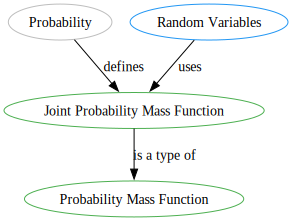

In [12]:
kg = pydantic_output_parser.parse(output_graph_json_dict)

visualize_knowledge_graph(kg)

Yaaay victory!!! Now, let's wrap this into a modified version of the original chain by using the RunnableLambda Object to do the 
intermediary step we were doing before.

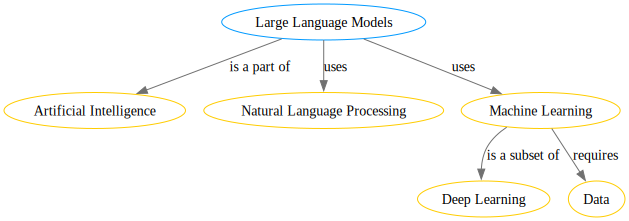

In [14]:
from langchain.utils.openai_functions import convert_pydantic_to_openai_function
from langchain.schema.runnable import RunnableLambda


def chain_diagram_viz():
    """Full chain to generate the formatted knowledge graph"""
    openai_function_knowledge_graph = convert_pydantic_to_openai_function(KnowledgeGraph)
    llm_chat = ChatOpenAI()    
    llm_with_tools = llm_chat.bind(functions=[openai_function_knowledge_graph])
    pydantic_output_parser = PydanticOutputParser(pydantic_object=KnowledgeGraph)
    return ChatPromptTemplate.from_template("Write a knowledge graph with the necessary concepts and elements to understand the following concept: '''{concept}''', this diagram should perfectly encapsulate\
        what it is and what it relates to.") | llm_with_tools | RunnableLambda(lambda x: x.additional_kwargs["function_call"]["arguments"]) | pydantic_output_parser
    # Here instead of using the RunnableLambda we could have used the JsonOutputFunctionsParser, however langchain and pydantic had some compatibility issues
    # so we're extracting the json dict manually and then parsing it with the PydanticOutputParser 
concept = "large language models" 

output_graph = chain_diagram_viz().invoke({"concept": concept})
visualize_knowledge_graph(output_graph)

Nice! How about we put everything together under a class that represents this LangChain implementation of the ADEPT method?

In [15]:
from dataclasses import dataclass
from typing import Any
from langchain.prompts import ChatPromptTemplate
from langchain.schema.runnable import RunnableParallel
from langchain.chat_models import ChatOpenAI

@dataclass
class ADEPT:
    concept: str
    llm_chat = ChatOpenAI()
    
    def chain_analogy(self):
        return ChatPromptTemplate.from_template("Write a simple analogy for this concept: '''{concept}''', which should perfectly encapsulate\
            what it is.") | llm_chat

    
    def chain_diagram_viz(self):
        """Full chain to generate the formatted knowledge graph"""
        openai_function_knowledge_graph = convert_pydantic_to_openai_function(KnowledgeGraph) 
        llm_with_tools = llm_chat.bind(functions=[openai_function_knowledge_graph])
        pydantic_output_parser = PydanticOutputParser(pydantic_object=KnowledgeGraph)
        return ChatPromptTemplate.from_template("Write a knowledge graph with the necessary concepts and elements to understand the following concept: '''{concept}''', this diagram should perfectly encapsulate\
            what it is and what it relates to.") | llm_with_tools | RunnableLambda(lambda x: x.additional_kwargs["function_call"]["arguments"]) | pydantic_output_parser
        

    def chain_example(self):
        return ChatPromptTemplate.from_template("Write down five examples that perfectly demonstrate this concept: '''{concept}'''. ") | llm_chat


    def chain_plain_english(self):
        return ChatPromptTemplate.from_template("Write a plain english definition for this concept: '''{concept}'''") | llm_chat


    def chain_technical_definition(self):
        return ChatPromptTemplate.from_template("Write a short and precise technical definition for this concept: '''{concept}'''") | llm_chat
    
    def visualize_knowledge_graph(self, kg: KnowledgeGraph):
        dot = Digraph(comment="Knowledge Graph")

        # Add nodes
        for node in kg.nodes:
            dot.node(str(node.id), node.label, color=node.color)

        # Add edges
        for edge in kg.edges:
            dot.edge(str(edge.source), str(edge.target), label=edge.label, color=edge.color)

        # Render the graph
        display(graphviz.Source(dot.source))
        
    # now let's write a __call__ method that runs all of the chains and generates a nice output just from the concept input.
    def __call__(self):
        analogy_chain = self.chain_analogy()
        diagram_chain = self.chain_diagram_viz()
        example_chain = self.chain_example()
        plain_english_chain = self.chain_plain_english()
        technical_definition_chain = self.chain_technical_definition()
        map_chain = RunnableParallel(analogy=analogy_chain, diagram=diagram_chain, example=example_chain, 
                             plain_english=plain_english_chain, technical_def=technical_definition_chain)
        output_explanation = map_chain.invoke({"concept": self.concept})
        return output_explanation


In [23]:
concept = "langchain python library"

adept = ADEPT(concept)
adept

ADEPT(concept='langchain python library')

In [24]:
output_explanation = adept()

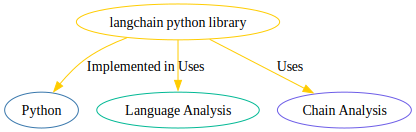

In [25]:
diagram = output_explanation["diagram"]

adept.visualize_knowledge_graph(diagram)

In [26]:
output_explanation["analogy"].content

'The "langchain python library" is like a versatile toolbox for language enthusiasts. Just as a library offers a wide range of books on various subjects, this python library provides a vast collection of tools and resources for working with different languages. It allows you to easily analyze, manipulate, and understand languages, just like browsing through books in a library helps you explore and gain knowledge in different areas.'

In [27]:
output_explanation["example"].content

'1. A user can import the langchain python library into their Python project and use its functions to analyze the sentiment of a given text. The library provides pre-trained sentiment analysis models, making it easy for the user to determine whether a text has a positive, negative, or neutral sentiment.\n\n2. The langchain python library offers a feature for language detection. By utilizing this library, a user can input a piece of text, and the library will automatically detect the language in which the text is written. This can be useful in various applications such as multilingual chatbots or language-specific data analysis.\n\n3. The library provides a translation function that allows users to translate text from one language to another. For instance, a user can input an English sentence and specify the target language as Spanish, and the library will return the translated version of that sentence. This can be beneficial for applications that require multilingual support.\n\n4. Wit

In [28]:
output_explanation["plain_english"].content

'The langchain python library is a software tool that helps developers work with programming languages and understand how they are related or connected to each other.'

In [29]:
output_explanation["technical_def"].content

'The langchain python library refers to a software package written in the Python programming language that provides a set of functions and tools for working with the Langchain programming language.'